In [129]:
# Master Script - Parallel Grid LCPC Transform

# By David H. Nguyen, PhD. Tissue Spatial Geometrics Lab (www.TSG-Lab.org)
# Citation: David H. Nguyen (2018). "Translating the Architectural Complexity of the Colon or Polyp into a 
#           Sinusoid Wave for Classification via the Fast Fourier Transform." ArXiv:1801.06752 [q-bio.TO]

#### Instructions ####
# 1. Load the dependencies or install them first before loading.
# 2. You need to paste in the file path for variable called "working_directory" in Step 1. Then run this and all cells below it. 
# 3. The input files should be images that contain blue lines on a white background (See Figure 1).
#    These outlines are open masks representing the shape that you want to analyze using the Parallel Grid LCPC Transform. 
# 4. The final result is a csv file called "compiled_fft_ParallelGridLCPC.csv". 
#    For each input file, four files will be produced (See Figure 2).

# Note: For those who are adapting this script for their own code, this script has 5 Parts. 
#       Each part begins with a markdown cell (example: "Part-1"). The beginning of each part has comments explaining what that part does. 


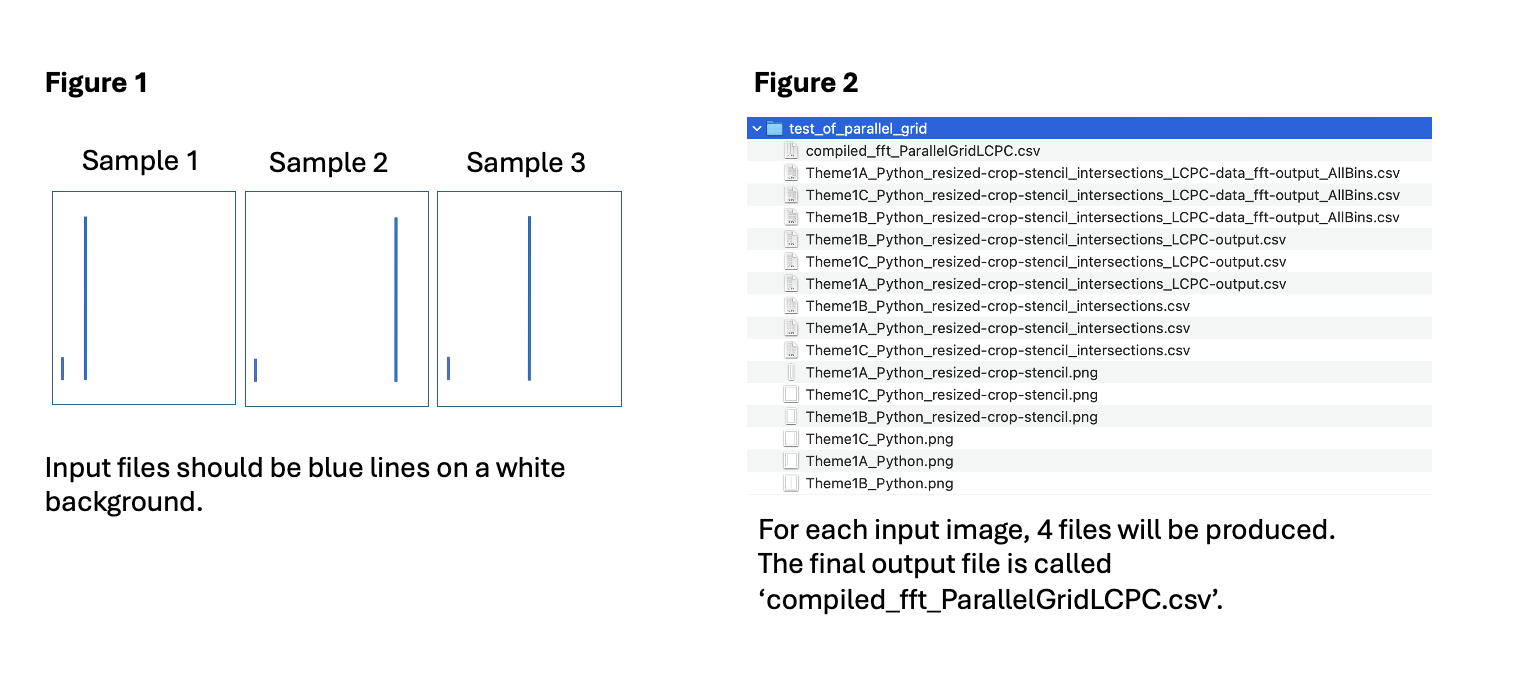

In [36]:
# Load The Dependencies

import os
import platform
import cv2 as cv2
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import imutils
import math
from numpy.fft import fft, ifft


In [170]:
# Step 1 - Set working directory

working_directory = '/Users/davidnguyen/Documents/Dave Personal Stuff/TSG Lab/Shape Genie OpS/Python Scripts for LCPC/Original Scripts_LCPC_Parallel Grid_for TSGL and Github/Master Script/Example_X_rectangle heights'

os.chdir(working_directory)
path = os.getcwd()
#print(path)
contents = os.listdir(path)

# Remove dot-prefixed hidden files (for Mac computers (Unix-like systems))
if platform.system() != 'Windows':
    contents = [item for item in contents if not item.startswith(".")]

contents

['Rectangle-Short.tif', 'Rectangle-Medium.tif', 'Rectangle-Tall.tif']

# Part-1

Rectangle-Short.tif
Rectangle-Medium.tif
Rectangle-Tall.tif


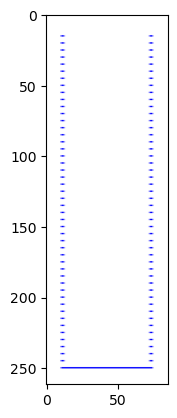

In [172]:
# Part 1 - Create the stencil representing intersections between the outline and the parallel grid system

for stuff in contents:

    ####################################################################################
    ####################################################################################
    ####################################################################################
    # Load the image and copy its name as a string for use in renaming output files

    ########
    # this function copies the name of the file that is passed into and returns that name
    def name_copier(y):
        fileName = y
        return(fileName)

    # This function returns TWO values. This function loads an image's name into cv2.imread, which is stored as "the_im",
    # and then passes that name to be returned as a string that is stored as "theName"
    def img_loader(x):
        img = f'cv2.imread("{x}")'
        nombre = name_copier(x)
        return eval(img), nombre
    ########

    # Load the image and copy its name
    the_im, theName = img_loader(stuff)
    plt.imshow(the_im)
    print(theName)

    plt.imshow(cv2.cvtColor(the_im, cv2.COLOR_BGR2RGB))
    
    
    
    ####################################################################################
    ####################################################################################
    ####################################################################################
    # Step 1 - Resize Image to 600xH(constrained ratio) [Scaling Step]. 
    #   The dimensions of 600xH(constrained ratio) is an arbitrary convention that we kept since the earliest versions of the script.

    # Resize the image 

    height = the_im.shape[0]
    # height
    width = the_im.shape[1]
    # width
    aspect_ratio = width/height

    height, width, aspect_ratio


    # calculate new how much to reduce width so that is becomes 600. 
    w_reduxPercent = 600/width
    w_reducedTo = int(width * w_reduxPercent)

    w_reduxPercent, w_reducedTo


    # calculate new height by multiplying it to the width-reduction-percent
    h_reducedTo = int(height * w_reduxPercent)
    h_reducedTo

    # define the new dimensions into a tuple
    dim = (w_reducedTo, h_reducedTo) # the new width and height


    # resize the image
    resized = cv2.resize(the_im, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))



    ####################################################################################
    ####################################################################################
    ####################################################################################
    # Step 2 - Crop Image but with a 10-pixel border on 4 sides

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

    blur = cv2.GaussianBlur(gray, (3,3), 0)
    plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

    thresh = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY_INV)[1]
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

    # This finds each indpendent shape in the image as contours. The output ranks the contours from 
    #    smallest to largest, so index 0 is the smallest one: 1st=len(cnts[0][0]), 2nd=len(cnts[0][1]), 3rd=len(cnts[0][2]), etc.
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # These four lists will collect the x, y, w, or h value from each item in cnts
    list_of_x = []
    list_of_y = []
    list_of_w = []
    list_of_h = []

    # This function appends the x,y,w,h values to the collection lists defined above
    def isolate_contours(input):
        x,y,w,h = cv2.boundingRect(cnts[0][input])
        list_of_x.append(x)
        list_of_y.append(y)
        list_of_w.append(w)
        list_of_h.append(h)

    # This creates an array matching the number of contours in cnts (which is cnts[0])
    numb_of_cnts = np.arange(0,len(cnts[0]))

    # this applies isolate_contours() to each item in numb_of_cnts
    for item in numb_of_cnts:
        isolate_contours(item)

    # list_of_x, list_of_y, list_of_w, list_of_h


    #   xM    xO     yM   yO    wM  wO   hM   hO
    # ([281, 315], [242, 219], [3, 30], [14, 38])


    # Find Left-Most Edge
    # To find the left most edge of all objects, just take the min of list_of_x
    left_edge = min(list_of_x)



    #### Start Section - Find Right-MostEdge

    # To find the right most edge of all objects, you need to first calculate this value for each object. 
    #   Then select the largest value.

    # this list will collect right-most x values for each contour
    list_of_rightside_x = []

    # this the function
    def calc_right_most_x(input):
        rightmost = list_of_x[input] + list_of_w[input]
        list_of_rightside_x.append(rightmost)

    # this is the range over which to iterate calc_right_most_x()    
    numb_of_rightmosts = np.arange(0,len(list_of_x))    

    # this for loop applies iterate calc_right_most_x() across numb_of_rightmosts
    for item in numb_of_rightmosts:
        calc_right_most_x(item)

    # this finds the furthest x within the list    
    right_edge = max(list_of_rightside_x)
    # right_edge   

    #### End Section



    # Find Top-Most Edge    
    # To find the top most edge of all objects, just take the min of list_of_y
    top_edge = min(list_of_y)



    #### Start Section - Find Bottom-Most Edge
    # To find the BOTTOM MOST edge of all objects, you need to first calculate this value for each object. 
    #   Then select the largest value.

    # this list will collect bottom-most y values for each contour
    list_of_bottom_y = []

    # this the function
    def calc_bottom_most_y(input):
        bottom_most = list_of_y[input] + list_of_h[input]
        list_of_bottom_y.append(bottom_most)

    # this is the range over which to iterate calc_bottom_most_y()    
    numb_of_bottom_mosts = np.arange(0,len(list_of_y))    

    # this for loop applies iterate calc_bottom_most_y() across numb_of_bottom_mosts
    for item in numb_of_bottom_mosts:
        calc_bottom_most_y(item)

    # this finds the furthest x within the list    
    bottom_edge = max(list_of_bottom_y)
    # bottom_edge  

    #### End Section


    # left_edge, right_edge, top_edge, bottom_edge    




    # Define new margins -- for cropping -- by adding a 10-pixel border around on four sides

    leftMinus10 = left_edge-10

    rightPlus10 = right_edge+10

    topPlus10 = top_edge-10

    bottomPlus10 = bottom_edge+10

    # leftMinus10, rightPlus10, topPlus10, bottomPlus10



    # Crop the resized image based on the new margins defined in the previous step
    cropped_image = resized[topPlus10:bottomPlus10, leftMinus10:rightPlus10]
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))



    ####################################################################################
    ####################################################################################
    ####################################################################################
    # Step 3 - Overlay horizontal white lines to create a stencil of the image

    
    # Step 3a - Define the pixel distance between the white lines that will erase things underneath them

    # x1 and x2 below are constant for every horizontal line that will be drawn
    x1 = 0 # this is the x coordinate of the starting point of a horizontal line
    x2 = cropped_image.shape[1] # this is the x coordinate of the end point of a horizontal line
    # x1, x2


        # write a function that executes cv2.rectangle()
    def lineDrawer(i, j):
        cv2.rectangle(cropped_image, (x1, i), (x2, j), (255, 255, 255),-1)

    # Create a range of numbers that will be the y1 coordinate -- the "i" input -- for drawing the rectangles in the function called lineDrawer
    y1_coords_4_rects = np.arange(1, cropped_image.shape[0], 5)
    # y1_coords_4_rects

    # Create a range of numbers that will be the y2 coordinate -- the "j" input -- for drawing the rectangles in the function called lineDrawer
    y2_coords_4_rects = np.arange(4, cropped_image.shape[0], 5)
    # y2_coords_4_rects

    # y1_coords_4_rects will be 1 item longer thany2_coords_4_rects, so delete the last item in y1_coords_4_rects to make 
    #   both of them the same length
    if len(y1_coords_4_rects) > len(y2_coords_4_rects):
        items_diff = len(y1_coords_4_rects) - len(y2_coords_4_rects) # this is the difference in their lengths
        y1_coords_4_rects = y1_coords_4_rects[:-items_diff]

    # y1_coords_4_rects, y2_coords_4_rects


    # input the two lists into the function draws white rectangles on the cropped image
    for i, j in zip(y1_coords_4_rects, y2_coords_4_rects):
        lineDrawer(i,j)


    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))


    # strip the file extension off of the file name
    split_string = theName.split(".", 1)
    strippedName = split_string[0]

    # add suffix to image that will be saed
    new_name = f'{strippedName}_resized-crop-stencil.png' 

    # save the stencil image
    cv2.imwrite(new_name, cropped_image) 


# Part-2 

In [174]:
# Part-2 - Notes

# Note: The input files for this script should have the string 'resized-crop-stencil' at the end of their file name. 
#       They were produced by "Part-1_Parallel Grid LCPC".

# 1. This script turns an image to gray scale, then thresholds it to find the brightest objects, 
#      then finds the contours of each object.
# 2. This script then calculates the midpoint of each object.
# 3. It then calculates the length of each object in the image.
# 4. It then calculates the midpoint of each object.
# 5. It then calculates the distance between each midpoint to the left edge of the image.
# 6. It then duplicates all rows (because each object is a row) whose length is greater than 7-pixels long. 


In [175]:
# Call the working directory again to update the list of files that are present in it
os.chdir(working_directory)
path = os.getcwd()
#print(path)
contents = os.listdir(path)

# Create a list of files that have the word "resized-crop-stencil" in their name
substring = 'resized-crop-stencil'
contents = [i for i in contents if substring in i]
contents

['Rectangle-Short_resized-crop-stencil.png',
 'Rectangle-Medium_resized-crop-stencil.png',
 'Rectangle-Tall_resized-crop-stencil.png']

In [176]:
# Part-2 - Main Script of Part 2

for item in contents:

    # Load the image and copy its  name as a string for use in renaming output files

    ########
    # this function copies the name of the file that is passed into and returns that name
    def name_copier(y):
        fileName = y
        return(fileName)

    # This function returns TWO values. This function loads an image's name into cv2.imread, which is stored as "the_im",
    # and then passes that name to be returned as a string that is stored as "theName"
    def img_loader(x):
        img = f'cv2.imread("{x}")'
        nombre = name_copier(x)
        return eval(img), nombre
    ########


    # Part 1A.2: Load the image and copy its name
    the_im, theName = img_loader(item)
    #plt.imshow(the_im)
    print(theName)

    #plt.imshow(cv2.cvtColor(the_im, cv2.COLOR_BGR2RGB))


    ####################################################################################
    ####################################################################################
    # Step 1 - Conver to gray scale, threshold to white on black, then find contours

    gray = cv2.cvtColor(the_im, cv2.COLOR_BGR2GRAY)
    #plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

    thresh = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)[1]
    #plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

    # This finds each indpendent shape in the image as contours. The output ranks the contours from 
    #    smallest to largest, so index 0 is the smallest one: 1st=len(cnts[0][0]), 2nd=len(cnts[0][1]), 3rd=len(cnts[0][2]), etc.
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



    ####################################################################################
    ####################################################################################
    # Step 2 - calculate the midpoint of each object.

    # create function that prints object-1 ... object-n. These will be row names for each contour in the image.

    object_name = []

    def name_each_contour(input):
        nombre = f'object-{input}'
        object_name.append(nombre)

    for i in np.arange(1,(len(cnts[0])+1)):
        name_each_contour(i)

    #object_name


    def raw_x_coord_extractor(input):
        x1 = cnts[0][input][0][0][0]
        list_of_raw_x1.append(x1)

        if len(cnts[0][input]) == 2:
            x2 = cnts[0][input][1][0][0]
            list_of_raw_x2.append(x2)
        else:
            x2 = "na"
            list_of_raw_x2.append(x2)

        center_y = cnts[0][input][0][0][1]
        list_of_y.append(center_y)

    list_of_raw_x1 = []
    list_of_raw_x2 = []
    list_of_y = []

    for i in np.arange(0,len(cnts[0])):
        raw_x_coord_extractor(i)

    #len(list_of_raw_x1), len(list_of_raw_x2), len(list_of_y)


    #list_of_raw_x1, list_of_raw_x2, list_of_y

    # zip the object_name and 3 numberical lists into a tuple of 4 columns, in the follow specifc order
    data_tuples = list(zip(object_name, list_of_raw_x1, list_of_raw_x2, list_of_y))
    #data_tuples

    # turn the tuple of 3 columns into a dataframe. Rename the column headers with the following names.
    df = pd.DataFrame(data_tuples, columns=['name','x1-raw','x2-raw','y']) 
    #df



    ####################################################################################
    ####################################################################################
    # Step 3 - Calculate the length of each ojbect.
    # Step 4 - Calculate the midpoint of each object.

    center_x = []
    length = []


    def subtract_then_divide(i,j): # i is column x1-raw, j is column x2-raw
        object_length = round(abs(i-j)) # |x1-raw - x2-raw|
        half_width = object_length/2 
        new_x = i + half_width # this gives the x-coordinate of the center of the object
        center_x.append(new_x)
        length.append(object_length)


    # separate datafram based on x2-raw column: all rows with numbers into df_nonNA; all rows with na into df_na
    df_nonNA = df[df['x2-raw'] != "na"] 
    #df_nonNA

    for (m,n) in zip(df_nonNA["x1-raw"],df_nonNA["x2-raw"]):
        command = f'subtract_then_divide({m},{n})'
        eval(command)

    len(center_x), len(length), center_x, length

    df_nonNA_v2 = df_nonNA.assign(length = length)
    #df_nonNA_v2

    df_nonNA_final = df_nonNA_v2.assign(x = center_x)
    #df_nonNA_final

    # Now work on the ojbects that do not have left. They are just once pixel long.

    df_na = df[df['x2-raw'] == "na"] 
    #df_na

    # Create a column of 1's to represent their length, because they are all 1-pixel long

    length_na = []

    for i in range(df_na.shape[0]):
        length_na.append(1)

    #length_na

    # add length_na as a column to df_na

    df_na_v2 = df_na.assign(length = length_na)
    #df_na_v2

    df_na_final = df_na_v2.assign(x = df_na["x1-raw"])
    #df_na_final

    # combine the two dataframes, df_nonNA_final and df_na_final
    df_reunited = pd.concat([df_nonNA_final, df_na_final])
    #df_reunited

    # this makes sure that your reunited dataframe as the same number of rows as the starting dataframe!
    error_checklist = []

    if df.shape[0] == df_reunited.shape[0]:
        error_checklist.append("Step 2: Congrats! 'df_reunited' has the same number of rows as 'df'.")
        for i in range(10):    
            print("Congrats! 'df_reunited' has the same number of rows as 'df'.")


    ###############################################################################
    ###############################################################################
    # Step 5 - Calculate distance between each object and the left edge of the image


    # Distance Equation between two points in Cartesian space:
    # sqrt( (x-x0)**2 + (y-y0)**2 )

    # Since we are measuring the distance of each ojbect to the left edge that is horizontally across the image,
    #  the (y-y0)**2 term is automatically 0 because y=y0. Thus, for the purposes of this script, the distance is
    #  just sqrt( (x-x0)**2 ). Furthermore, since x0 is always 0 (because it's the left edge of the image) the 
    #  sqrt(x**2) is just x! So no need to do any calculations for distance because the x column in df_reunited is 
    #  already the distance between each object from the left edge of the image!


    ############################################################################### ###############################################################################
    # Step 6 - Duplicates all rows whose length is greater than 7-pixels long. 

    # filter for rows that whose value in the "length" column is greater than 7
    greater_than_7 = df_reunited.loc[df_reunited['length'] > 7] 
    #greater_than_7

    # Add rows in "greater_than_7" to df_reunited, which results in duplicating all rows in df_reunited 
    #  that had length > 7

    df_longItemsDuplicated = pd.concat([df_reunited, greater_than_7])
    #df_longItemsDuplicated

    # strip the file extension off of the file name
    split_string = theName.split(".", 1)
    strippedName = split_string[0]

    # add suffix to image that will be saed
    new_name = f'{strippedName}_intersections.csv' 

    # save the stencil image
    df_longItemsDuplicated.to_csv(new_name, index=False)        




Rectangle-Short_resized-crop-stencil.png
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Rectangle-Medium_resized-crop-stencil.png
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Congrats! 'df_reunited' has the same number of rows as 'df'.
Co

# Part 3

In [178]:
# Part-3 - Notes

# 1. This script isolates all objects that are on the same horizontal line. 
#      The number of horizontal lines start from 0 to the maximum value in the "y" column of the input file.
# 2. The script then sums the distances (the values in the column called "x") of these objects for each line. 
#      The result is that each line/angle from 0, 5, 10, 15,...,etc. has only ONE value. 
# 3. The script then creates a dataframe of two columns: 
#
#    angle                   summed_distances
#    -------                 ------
#    sum_dist_for_angle_0    0.0
#    sum_dist_for_angle_5    0.0
#    sum_dist_for_angle_10   50.0
#
# 4. It then creates an output file this is a csv file that ends with "_LCPC-output.csv"



In [179]:
# call the working directory again to update the list of files in it contains

os.chdir(working_directory)
path= os.getcwd()
print(path)
contents = os.listdir(path)

# Create a list of files that have the phrase "resized-crop-stencil_intersections" in their name
substring = 'intersections'
contents = [i for i in contents if substring in i]
contents

/Users/davidnguyen/Documents/Dave Personal Stuff/TSG Lab/Shape Genie OpS/Python Scripts for LCPC/Original Scripts_LCPC_Parallel Grid_for TSGL and Github/Master Script/Example_X_rectangle heights


['Rectangle-Short_resized-crop-stencil_intersections.csv',
 'Rectangle-Tall_resized-crop-stencil_intersections.csv',
 'Rectangle-Medium_resized-crop-stencil_intersections.csv']

In [180]:
# Part-3 - Main code 

for item in contents:

    ########
    # this function copies the name of the file that is passed into and returns that name
    def name_copier(y):
        fileName = y
        return(fileName)

    # This function returns TWO values. This function loads a file name into pd.read_csv, which is stored as "table",
    # and then passes that file to the name_copier function to get a string that is stored as "nombre"
    def df_reader(x):
        table = f'pd.read_csv("{x}")'
        nombre = name_copier(x)
        return eval(table), nombre
    ########

    df, df_name = df_reader(item)
    # df


    #################################################################
    ##################################################################
    # Step 1 - Find the number of horizontal lines for image represented by the dataframe that was loaded. 
    # You can do this from the table by finding the largest value in the "y" column

    # This variable represents the maximum horizontal line in the stenciled image from the Step 1 output.  
    furthest_line = df["y"].max()
    # furthest_line


    # Create list of angle measures: a list of numbers ranging from 0 to "furthest_line + 5" by step size of 5. 
    #    5 is added because Python's indexing is non-inclusive for the "stop" argument in the function "np.arange()"
    degrees = np.arange(start = 0, stop = (furthest_line+5), step = 5)
    # degrees


    # Create actual variables that are empty lists. They will receive dataframes from the function assign_to_subgroups() 

    # They should be called:
    # rows_in_angle_0 
    # rows_in_angle_5
    # rows_in_angle_10
    #  ...
    # rows_in_angle_180


    for i in degrees:
        command = "" # this line is here to clear out the previous command
        command = "rows_in_angle_" + str(i) + " = []"
        exec(command)


    # Also create a list that contains all these variable names, so they can be iterated over. 
    #    Call this list "list_of_subgroups"
    list_of_subgroups = []

    for i in degrees:
        command = "" # this line is here to clear out the previous command
        command = "rows_in_angle_" + str(i)
        list_of_subgroups.append(command)

    # list_of_subgroups


    num_of_angles = np.arange(0,len(list_of_subgroups))

    collection_basket = []

    for (i) in zip(degrees):
        # filter rows in df that match i, name it as a unique dataframe, sum the values in the length column of this new dataframe
        group = df.loc[df['y'] == i]
        collection_basket.append(group)
    #     print(group)

    # collection_basket


    # turn each item in collection_basket into a unique variable in the global environment

    def assign_to_subgroups(i):
        list_of_subgroups[i] = collection_basket[i]

    for i in range(len(list_of_subgroups)):
        assign_to_subgroups(i)


    # create a list of empty variable names that will be assigned content later

    # The variables should be named:
    # sum_lengths_0
    # sum_lengths_5
    # sum_lengths_10
    # ...
    # sum_lengths_180


    list_of_summed_lengths = []

    for i in degrees:
        command = "" # this line is here to clear out the previous command
        command = "sum_dist_for_angle_" + str(i)
        list_of_summed_lengths.append(command)

    # list_of_summed_lengths


    #################################################################
    ##################################################################
    # Step 2

    # Create a copy of list_of_summed_lengths. This copy, called values_of_summed_lengths, will receive 
    # numbers from the function called calc_sums

    values_of_summed_lengths = list_of_summed_lengths.copy()
    # values_of_summed_lengths


    # this function calculates the sum of the "length" column in the dataframes in list_of_subgroups and assigns 
    # them to the corresponding variables in values_of_summed_lengths

    def calc_sums(i):
        values_of_summed_lengths[i] = list_of_subgroups[i]["x"].sum()



    for i in range(len(list_of_subgroups)):
        calc_sums(i)



    # combine the two lists into a dataframe: list_of_summed_lengths & values_of_summed_lengths
    new_df = pd.DataFrame(
        {'angle': list_of_summed_lengths,
         'summed_distances': values_of_summed_lengths
        })

    # new_df



    # save result as a csv file

    # strip the file extension off of the file name
    split_string = df_name.split(".", 1)
    strippedName = split_string[0]

    # add suffix to image that will be saed
    new_name = f'{strippedName}_LCPC-output.csv' 

    # save the stencil image
    new_df.to_csv(new_name, index=False)



# Part-4

In [182]:
# Part-4 - Notes

# This script does the FFT on a column of data. 
#   This script outputs a csv file with the words "_fft-output_AllBins" at the end of its file name.

# NOTE 1: The sampling rate is set to 40. See variabled called "samp_rate".
# We pick a sampling rate of 40 because the original way we did it was to divide a 200 pixel-tall image by 5 pixels, 
#  resulting in 40 horizontal lines. Changing the sampling rate changes the resulting frequencies
#  but does NOT change the resulting magnitudes. Since we are interested in just the magnitudes and not the
#  frequencies, the sampling rate doesn't really matter. 

    
# How To Use This Script:    
#   This script takes a csv file that was outputted from the previous step. 
#   The input file must have "LCPC-data" at the end of its file name. Each unique sample should only have one 
#      file that has this phrase in it's file name. 
#   The input file must have a column called "summed_distances".


In [183]:
# call the working directory again to update the list of files in it contains

os.chdir(working_directory)
path= os.getcwd()
print(path)
contents = os.listdir(path)

# Create a list of files that have the word "stencil_intersections_LCPC-output" in their name
substring = 'stencil_intersections_LCPC-output'
contents = [i for i in contents if substring in i]
contents

/Users/davidnguyen/Documents/Dave Personal Stuff/TSG Lab/Shape Genie OpS/Python Scripts for LCPC/Original Scripts_LCPC_Parallel Grid_for TSGL and Github/Master Script/Example_X_rectangle heights


['Rectangle-Short_resized-crop-stencil_intersections_LCPC-output.csv',
 'Rectangle-Tall_resized-crop-stencil_intersections_LCPC-output.csv',
 'Rectangle-Medium_resized-crop-stencil_intersections_LCPC-output.csv']

In [184]:

for item in contents:
    
    ########
    # this function copies the name of the file that is passed into and returns that name
    def name_copier(y):
        fileName = y
        return(fileName)

    # This function returns TWO values. This function loads a file name into pd.read_csv, which is stored as "table",
    # and then passes that file to the name_copier function to get a string that is stored as "nombre"
    def df_reader(x):
        table = f'pd.read_csv("{x}")'
        nombre = name_copier(x)
        return eval(table), nombre
    ########

    df, df_name = df_reader(item)

    # turn the column calld 'summed_distances' into a list
    data = df['summed_distances'].tolist()
    # data

    # Define the sampling rate. See the introduction of this script for why a sampling rate of 40 was chosen. 
    samp_rate = 40
    
    # Do the FFT
    fft_result = fft(data)
    N = len(fft_result)
    n = np.arange(N)
    T = N/samp_rate
    freq = n/T 

    #####
    # The next few lines of code are for plotting the fft spectrum
    #plt.figure(figsize = (12, 6))
    #plt.subplot(121)

    #plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
    #plt.xlabel('Freq (Hz)')
    #plt.ylabel('FFT Amplitude |X(freq)|')
    #plt.xlim(0, 20)
    #plt.show()
    #####

    ###############################
    # calculate the magnitudes by taking absolute value of the variable called fft_result
    magnitudes = np.abs(fft_result)
    
    # calculate the single-sided magnitude by multiplying the magnitudes by 2
    single_sided_magnitudes = magnitudes * 2
    
    
    # create a list of numbers to track each row along the length of fft_result, which is the variable N
    counter = np.arange(1,N,1)

    ################################
    # combine counter, freq, and single_sided_magnitudes into a dataframe
    # This script does collects ALL frequencies for each sample, not just the smallest 19.    
    final_df = pd.DataFrame(list(zip(counter, freq, single_sided_magnitudes)), columns=['order','freq','single.sided.magnitude'])
    
    #################################
    # save result as a csv file

    # strip the file extension off of the file name
    split_string = df_name.split("LCPC-output", 1)
    strippedName = split_string[0]
        
    # add suffix to image that will be saved
    new_name = f'{strippedName}LCPC-data_fft-output_AllBins.csv' 

    # save the dataframe image
    final_df.to_csv(new_name, index=False)


    
    


# Part-5

In [186]:
# Part-5 - Notes

# Purpose: This script isolates the magnitude column from each fft ouput from Step 4 and combines them all 
#  into one dataframe.


# How To Format the Input File:
#   Each input file should have the phrase "fft-output" in it's file name. Each sample should have only ONE csv file
#     that has this phrase in it.
#   Each input file should have a column whos header is called "single.sided.magnitude". 
#   Each input file should have the word "mask" in it's name or the naming of the columns in the output file will 
#     have a very long name, which still works. 

#   This script creates a csv output file with the generic name of "compiled fft.csv"


In [187]:
# call the working directory again to update the list of files in it contains

os.chdir(working_directory)
path= os.getcwd()
print(path)
contents = os.listdir(path)

# Create a list of files that have the word "LCPC-data_fft-output_AllBins" in their name
substring = 'LCPC-data_fft-output_AllBins'
contents = [i for i in contents if substring in i]
sorted_contents = sorted(contents) # sort alphabetically from a to z
sorted_contents


/Users/davidnguyen/Documents/Dave Personal Stuff/TSG Lab/Shape Genie OpS/Python Scripts for LCPC/Original Scripts_LCPC_Parallel Grid_for TSGL and Github/Master Script/Example_X_rectangle heights


['Rectangle-Medium_resized-crop-stencil_intersections_LCPC-data_fft-output_AllBins.csv',
 'Rectangle-Short_resized-crop-stencil_intersections_LCPC-data_fft-output_AllBins.csv',
 'Rectangle-Tall_resized-crop-stencil_intersections_LCPC-data_fft-output_AllBins.csv']

In [188]:
# Part-5 - Main code

# create an empty list that will receive contents later
list_o_numRows = []

# This for-loop opens a csv file, counts the number of rows in it, and then appends that number to list_o_numRows
for item in sorted_contents:
    df = pd.read_csv(item)
    how_many = df.shape[0]
    list_o_numRows.append(how_many) 

# Find the largest number in list_o_numRows, which will define the height of the empty dataframe that comes next.
#   This is necessary or the below for-loop will cut off rows from certain csv files
df_max_height = max(list_o_numRows)

# list_o_numRows, df_max_height


# Create an empty dataframe that will receive content later that has the number of rows specified by 
#   df_max_height and taking into account Python's indexing from 0
collector = np.arange(1,(df_max_height+1),1)
collector = pd.DataFrame(collector,columns=['bin_order'])
# collector


for item in sorted_contents:

    ########
    # this function copies the name of the file that is passed into and returns that name
    def name_copier(y):
        fileName = y
        return(fileName)

    # This function returns TWO values. This function loads a file name into pd.read_csv, which is stored as "table",
    # and then passes that file to the name_copier function to get a string that is stored as "nombre"
    def df_reader(x):
        table = f'pd.read_csv("{x}")'
        nombre = name_copier(x)
        return eval(table), nombre
    ########

    # the name of the input file is stored in the variable called df. it's name is stored as df_name
    df, df_name = df_reader(item)
    # df

    # isolate the column called single.sided.magnitude
    mags = df["single.sided.magnitude"]
    # mags

    # Split the name of the input file at the word "mask" and copy everything that comes before the word "mask"
    split_string = df_name.split("mask", 1)
    strippedName = split_string[0]

    # rename the column header with the modified file name stored in strippedName
    collector[strippedName] = mags
    #collector


# save collector as a csv file with a generic name
collector.to_csv("compiled_fft_ParallelGridLCPC.csv", index=False)